# Basic setup and helper functions

In [1]:
import json
import os
import os.path as osp
import sys
import time
from collections import defaultdict, namedtuple
from multiprocessing import Pool
from scipy.stats import norm

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

if "__file__" in globals():
    os.chdir(os.path.dirname(__file__) + "/..")
elif "pkg" not in os.listdir("."):
    os.chdir("..")
sys.path.append(".")

from pkg.helper import compute_kde_axis, estimated_autocorrelation
from pkg.models.model_two_layer_L96 import (
    EnsembleKalmanFilterSmootherL96,
    EnsembleKalmanFilterSmootherL96OneLayer,
    EnsembleKalmanFilterSmootherL96SPEKF,
)
from pkg.utils.misc import AverageMeter, savefig, set_rand_seed


def compute_mean_std(u_mean, u_std):
    return (
        u_mean + u_std,
        u_mean - u_std,
        u_mean + 2 * u_std,
        u_mean - 2 * u_std,
    )


%matplotlib inline
%load_ext autoreload
%autoreload 2

root_folder = "/grad/yli678/workspace/smoother_sampling/output/"
foldername = (
    "/Two_layer_L96_final/n_steps=500001,dim_I=40,sparse_obs=True,"
    + "f=4.0,h=2.0,b=2.0,c=2.0,sigma_obs=1.0,sigma_u=1.0,sigma_v=1.0"
)
output_path = root_folder + foldername

In [2]:
model = "L96"

In [3]:
Params = namedtuple(
    "Params",
    [
        "sigma_obs",
        "sigma_u",
        "sigma_v",
        "dim_I",
        "dim_J",
        "h",
        "b",
        "c",
        "f",
        "d_v",
        "v_hat",
        "sigma_v_hat",
    ],
)

json_filename = output_path + "/true_params_used.json"
with open(json_filename, "r") as f:
    configs_perfect = json.loads(f.read())

dim_I = configs_perfect["dim_I"]
dim_J = configs_perfect["dim_J"]

params_truth = Params(
    configs_perfect["sigma_obs"],
    configs_perfect["sigma_u"],  # sigma_u
    configs_perfect["sigma_v"],  # sigma_v,
    configs_perfect["dim_I"],  # dim_I
    configs_perfect["dim_J"],  # dim_J
    configs_perfect["h"],  # h
    configs_perfect["b"],  # b
    configs_perfect["c"],  # c
    configs_perfect["f"],  # f
    configs_perfect["d_v"],
    configs_perfect["v_hat"],
    configs_perfect["sigma_v_hat"],
)

json_filename = output_path + "/SPEKF_model_params.json"
with open(json_filename, "r") as f:
    configs_wrong = json.loads(f.read())

params_wrong = Params(
    configs_wrong["sigma_obs"],
    configs_wrong["sigma_u"],  # sigma_u
    configs_wrong["sigma_v"],  # sigma_v,
    configs_wrong["dim_I"],  # dim_I
    configs_wrong["dim_J"],  # dim_J
    configs_wrong["h"],  # h
    configs_wrong["b"],  # b
    configs_wrong["c"],  # c
    configs_wrong["f"],  # f
    configs_wrong["d_v"],
    configs_wrong["v_hat"],
    configs_wrong["sigma_v_hat"],
)


json_filename = output_path + "/onelayer_params.json"
with open(json_filename, "r") as f:
    configs_onelayer = json.loads(f.read())

params_onelayer = Params(
    configs_onelayer["sigma_obs"],
    configs_onelayer["sigma_u"],  # sigma_u
    configs_onelayer["sigma_v"],  # sigma_v,
    configs_onelayer["dim_I"],  # dim_I
    configs_onelayer["dim_J"],  # dim_J
    configs_onelayer["h"],  # h
    configs_onelayer["b"],  # b
    configs_onelayer["c"],  # c
    configs_onelayer["f"],  # f
    configs_onelayer["d_v"],
    configs_onelayer["v_hat"],
    configs_onelayer["sigma_v_hat"],
)
print(params_truth)
print(params_wrong)
print(params_onelayer)

json_filename = output_path + "/config.json"
with open(json_filename, "r") as f:
    configs = json.loads(f.read())

dt = configs["dt"]
obs_dt = configs["obs_dt"]
n_steps = configs["n_steps"]
rand_seed = configs["rand_seed"]
pred_start_time = configs["pred_start_time"]
pred_total_time = configs["pred_total_time"]
last_lead_time = configs["last_lead_time"]
model_dim = dim_I + dim_I * dim_J

data_sampling = np.load(output_path + "/sampling.npz")
true_state = data_sampling["true_state"]
obs = data_sampling["obs"]
gamma_mean_trace = data_sampling["gamma_mean_trace"]
gamma_cov_trace = data_sampling["gamma_cov_trace"]
data_sampling_perfect = np.load(output_path + "/sampling_perfect.npz")
gamma_mean_trace_perfect = data_sampling_perfect["gamma_mean_trace_perfect"]
gamma_cov_trace_perfect = data_sampling_perfect["gamma_cov_trace_perfect"]

data_sampling_onelayer = np.load(output_path + "/sampling_onelayer.npz")
gamma_mean_trace_onelayer = data_sampling_onelayer["gamma_mean_trace_onelayer"]
gamma_cov_trace_onelayer = data_sampling_onelayer["gamma_cov_trace_onelayer"]

data_sampling_for_IC = np.load(output_path + "/sampling_for_IC.npz")
gamma_ensembles_for_IC_short = data_sampling_for_IC[
    "gamma_ensembles_for_IC_short"
]

data_sampling_for_IC = np.load(output_path + "/sampling_for_IC_onelayer.npz")
gamma_ensembles_for_IC_short_onelayer = data_sampling_for_IC[
    "gamma_ensembles_for_IC_short"
]

Params(sigma_obs=1.0, sigma_u=1.0, sigma_v=1.0, dim_I=40, dim_J=4, h=2.0, b=2.0, c=2.0, f=4.0, d_v=None, v_hat=None, sigma_v_hat=None)
Params(sigma_obs=1.0, sigma_u=1.0, sigma_v=1.0, dim_I=40, dim_J=4, h=2.0, b=2.0, c=2.0, f=4.0, d_v=5.105431491840385, v_hat=0.4268366644533809, sigma_v_hat=2.0208180071196282)
Params(sigma_obs=1.0, sigma_u=1.0, sigma_v=1.0, dim_I=40, dim_J=0, h=2.0, b=2.0, c=2.0, f=4.0, d_v=None, v_hat=None, sigma_v_hat=None)


In [4]:
obs_n_steps = int(dt * (n_steps - 1) / obs_dt) + 1
K = int(obs_dt / dt)
t = np.linspace(0, (n_steps - 1) * dt, n_steps)
t_obs = np.linspace(0, (obs_n_steps - 1) * obs_dt, obs_n_steps)
obs_idx = np.linspace(0, int((obs_n_steps - 1)) * K, obs_n_steps)
obs_idx = obs_idx.astype(int)


obs_dims = configs["obs_dims"]
num_obs_dims = len(obs_dims)
trans_mat = np.zeros((num_obs_dims, model_dim))
for i in range(num_obs_dims):
    trans_mat[i, i] = 1
    trans_mat[i, obs_dims[i]] = 1
obs_noise = np.ones(num_obs_dims) * configs["sigma_obs"]

model_dim_onelayer = dim_I
trans_mat_onelayer = np.zeros((num_obs_dims, dim_I))
trans_mat_onelayer = trans_mat[:, :dim_I]
obs_noise_onelayer = obs_noise

In [5]:
data_sampling_for_IC = np.load(output_path + "/sampling_for_IC_perfect.npz")
gamma_ensembles_for_IC_short_perfect = data_sampling_for_IC[
    "gamma_ensembles_for_IC_short"
]

In [6]:
L96_EnKF = EnsembleKalmanFilterSmootherL96(
    n_steps, model_dim, params_truth, obs_dt, trans_mat, obs_noise, dt
)
L96_EnKF_SPEKF = EnsembleKalmanFilterSmootherL96SPEKF(
    n_steps, model_dim, params_wrong, obs_dt, trans_mat, obs_noise, dt
)
L96_EnKF_onelayer = EnsembleKalmanFilterSmootherL96OneLayer(
    n_steps,
    model_dim_onelayer,
    params_onelayer,
    obs_dt,
    trans_mat_onelayer,
    obs_noise_onelayer,
    dt,
)

# Model based prediction

In [7]:
pred_dt = obs_dt
pred_n_steps = int(dt * (n_steps - 1) / pred_dt) + 1
pred_K = int(pred_dt / dt)


t_pred = np.linspace(0, (pred_n_steps - 1) * pred_dt, pred_n_steps)
pred_idx = np.linspace(0, int((pred_n_steps - 1)) * pred_K, pred_n_steps)
pred_idx = pred_idx.astype(int)

In [8]:
pred_obs_n_steps = int(obs_dt * (obs_n_steps - 1) / pred_dt) + 1
pred_obs_K = int(pred_dt / obs_dt)


pred_obs_idx = np.linspace(
    0, int((pred_obs_n_steps - 1)) * pred_obs_K, pred_obs_n_steps
)
pred_obs_idx = pred_obs_idx.astype(int)

In [9]:
pred_start_pred_step = int(pred_start_time / pred_dt)
pred_total_pred_steps = int(pred_total_time / pred_dt) + 1

print(f"pred_start_pred_step: {pred_start_pred_step}")
print(f"pred_total_pred_steps: {pred_total_pred_steps}")

print(f"start time unit: {pred_start_pred_step * pred_dt}")
print(
    "end time unit: "
    + "f{(pred_start_pred_step + pred_total_pred_steps) * pred_dt}"
)
print(f"length of entire trajectories: {(n_steps - 1) * dt}")

last_lead_t = int(last_lead_time / dt)
lead_step = pred_K

pred_last_lead_t = last_lead_t // pred_K
pred_lead_step = lead_step // pred_K

lead_time_steps = np.linspace(
    0, last_lead_t, int(last_lead_t / lead_step) + 1
).astype(
    int
)  # only use for plotting
print(
    "lead_time_steps (in terms of in true trajectories space, dt):"
    + f" {lead_time_steps}"
)
print(f"final lead time: {last_lead_t * dt}")
print(f"total_lead_time_steps: {len(lead_time_steps)}")

pred_start_pred_step: 8000
pred_total_pred_steps: 1601
start time unit: 400.0
end time unit: f{(pred_start_pred_step + pred_total_pred_steps) * pred_dt}
length of entire trajectories: 500.0
lead_time_steps (in terms of in true trajectories space, dt): [   0   50  100  150  200  250  300  350  400  450  500  550  600  650
  700  750  800  850  900  950 1000 1050 1100 1150 1200 1250 1300 1350
 1400 1450 1500 1550 1600 1650 1700 1750 1800 1850 1900 1950 2000 2050
 2100 2150 2200 2250 2300 2350 2400 2450 2500 2550 2600 2650 2700 2750
 2800 2850 2900 2950 3000 3050 3100 3150 3200 3250 3300 3350 3400 3450
 3500 3550 3600 3650 3700 3750 3800 3850 3900 3950 4000 4050 4100 4150
 4200 4250 4300 4350 4400 4450 4500 4550 4600 4650 4700 4750 4800 4850
 4900 4950 5000]
final lead time: 5.0
total_lead_time_steps: 101


In [10]:
t_target = t[pred_idx][
    pred_start_pred_step : pred_start_pred_step + pred_total_pred_steps
]
target = true_state[pred_idx][
    pred_start_pred_step : pred_start_pred_step + pred_total_pred_steps
]

In [11]:
model_prediction_data = np.load(output_path + "/dynamicalmodels.npz")
predict_mean = model_prediction_data["predict_mean"]
predict_wrong = model_prediction_data["predict_wrong"]
rmse_perfect = model_prediction_data["rmse_perfect"]
rmse_wrong = model_prediction_data["rmse_wrong"]
corr_perfect = model_prediction_data["corr_perfect"]
corr_wrong = model_prediction_data["corr_wrong"]
predict_mean_DA = model_prediction_data["predict_mean_DA"]
predict_wrong_DA = model_prediction_data["predict_wrong_DA"]
rmse_perfect_DA = model_prediction_data["rmse_perfect_DA"]
rmse_wrong_DA = model_prediction_data["rmse_wrong_DA"]
corr_perfect_DA = model_prediction_data["corr_perfect_DA"]
corr_wrong_DA = model_prediction_data["corr_wrong_DA"]

In [12]:
predict_wrong_onelayer = model_prediction_data["predict_wrong_onelayer"]
rmse_wrong_onelayer = model_prediction_data["rmse_wrong_onelayer"]
corr_wrong_onelayer = model_prediction_data["corr_wrong_onelayer"]
predict_wrong_DA_onelayer = model_prediction_data["predict_wrong_DA_onelayer"]
rmse_wrong_DA_onelayer = model_prediction_data["rmse_wrong_DA_onelayer"]
corr_wrong_DA_onelayer = model_prediction_data["corr_wrong_DA_onelayer"]

## prediction spread

In [13]:
pred_num_ensembles = 2500
spread_total_pred_steps = 101
spread_initial_time = 10
spread_start_time = pred_start_time + spread_initial_time
spread_start_time_step = int(spread_start_time / pred_dt)
print(spread_start_time_step)
spread_target = true_state[pred_idx][
    spread_start_time_step : spread_start_time_step + spread_total_pred_steps
]
spread_t = t_pred[
    spread_start_time_step : spread_start_time_step + spread_total_pred_steps
]
spread_initial_values = true_state[pred_idx][spread_start_time_step]
spread_initial_values_repeat = np.zeros((pred_num_ensembles, model_dim))
spread_initial_values_repeat_onelayer = np.zeros((pred_num_ensembles, dim_I))
spread_initial_mean = gamma_mean_trace[pred_obs_idx][spread_start_time_step]
spread_initial_cov = gamma_cov_trace[pred_obs_idx][spread_start_time_step]
spread_initial_mean_onelayer = gamma_mean_trace_onelayer[pred_obs_idx][
    spread_start_time_step
]
spread_initial_cov_onelayer = gamma_cov_trace_onelayer[pred_obs_idx][
    spread_start_time_step
]
spread_initial_mean_perfect = gamma_mean_trace_perfect[pred_obs_idx][
    spread_start_time_step
]
spread_initial_cov_perfect = gamma_cov_trace_perfect[pred_obs_idx][
    spread_start_time_step
]

spread_initial_DA = np.zeros((pred_num_ensembles, model_dim))
spread_initial_DA_perfect = np.zeros((pred_num_ensembles, model_dim))
spread_initial_DA_onelayer = np.zeros((pred_num_ensembles, dim_I))

spread_initial_DA = np.random.multivariate_normal(
    spread_initial_mean, spread_initial_cov, pred_num_ensembles
)
spread_initial_DA_perfect = np.random.multivariate_normal(
    spread_initial_mean_perfect, spread_initial_cov_perfect, pred_num_ensembles
)

spread_initial_DA_onelayer = np.random.multivariate_normal(
    spread_initial_mean_onelayer,
    spread_initial_cov_onelayer,
    pred_num_ensembles,
)

8200


In [14]:
def model_prediction_spread(
    model, num_ensembles, initial_values, total_pred_steps, K=1
):
    model_dim = model.model_dim
    predicts_en = np.zeros((total_pred_steps, num_ensembles, model_dim))
    for i in range(num_ensembles):
        predicts_en[0, i] = initial_values[i]
    predicts_temps = predicts_en[0].copy()
    for i in tqdm(range(num_ensembles)):
        for j in range(1, total_pred_steps * K):
            predicts_temps[i] = model.simulate_state(
                predicts_temps[i], num_ensembles=1
            )
            if j % K == 0:
                predicts_en[j // K, i] = predicts_temps[i]
    return predicts_en

In [15]:
def model_prediction_spread_func_L96_EnKF_DA(i):
    initial_values = spread_initial_DA_perfect[i]
    model = L96_EnKF
    set_rand_seed(i)
    model_dim = model.model_dim
    total_pred_steps = spread_total_pred_steps
    predicts_en = np.empty((total_pred_steps, model_dim))
    predicts_en = [[0] * model_dim] * total_pred_steps
    predicts_en[0] = initial_values.tolist()
    predicts_temps = np.asarray(predicts_en[0])
    for j in range(1, total_pred_steps * K):
        predicts_temps = model.simulate_state(predicts_temps, num_ensembles=1)
        if j % K == 0:
            predicts_en[j // K] = predicts_temps.tolist()
    return predicts_en

In [16]:
def model_prediction_spread_func_L96_EnKF_SPEKF_DA(i):
    initial_values = spread_initial_DA[i]
    model = L96_EnKF_SPEKF
    set_rand_seed(i)
    model_dim = model.model_dim
    total_pred_steps = spread_total_pred_steps
    predicts_en = np.empty((total_pred_steps, model_dim))
    predicts_en = [[0] * model_dim] * total_pred_steps
    predicts_en[0] = initial_values.tolist()
    predicts_temps = np.asarray(predicts_en[0])
    for j in range(1, total_pred_steps * K):
        predicts_temps = model.simulate_state(predicts_temps, num_ensembles=1)
        if j % K == 0:
            predicts_en[j // K] = predicts_temps.tolist()
    return predicts_en

In [17]:
def model_prediction_spread_func_L96_EnKF_onelayer_DA(i):
    initial_values = spread_initial_DA_onelayer[i]
    model = L96_EnKF_onelayer
    set_rand_seed(i)
    model_dim = model.model_dim
    total_pred_steps = spread_total_pred_steps
    predicts_en = np.empty((total_pred_steps, model_dim))
    predicts_en = [[0] * model_dim] * total_pred_steps
    predicts_en[0] = initial_values.tolist()
    predicts_temps = np.asarray(predicts_en[0])
    for j in range(1, total_pred_steps * K):
        predicts_temps = model.simulate_state(predicts_temps, num_ensembles=1)
        if j % K == 0:
            predicts_en[j // K] = predicts_temps.tolist()
    return predicts_en

In [19]:
hhhh = list(range(pred_num_ensembles))
start_time = time.time()
set_rand_seed(rand_seed)
with Pool() as p:
    results_ = p.map(model_prediction_spread_func_L96_EnKF_DA, hhhh)
print(time.time() - start_time)

In [21]:
start_time = time.time()
predicts_en_DA = np.zeros((spread_total_pred_steps, pred_num_ensembles, 200))

In [22]:
for i in range(pred_num_ensembles):
    predicts_en_DA[:, i, :] = results_[i]
print(time.time() - start_time)

3.3548266887664795


In [24]:
np.savez_compressed(
    osp.join(output_path, "predicts_en_DA.npz"),
    spread_total_pred_steps=spread_total_pred_steps,
    spread_initial_time=spread_initial_time,
    predicts_en_DA=predicts_en_DA,
)

In [33]:
hhhh = list(range(pred_num_ensembles))
start_time = time.time()
set_rand_seed(rand_seed)
with Pool() as p:
    results_ = p.map(model_prediction_spread_func_L96_EnKF_SPEKF_DA, hhhh)
print(time.time() - start_time)

1564.1026623249054


In [34]:
start_time = time.time()
predicts_en_wrong_DA = np.zeros(
    (spread_total_pred_steps, pred_num_ensembles, 200)
)

In [35]:
for i in range(pred_num_ensembles):
    predicts_en_wrong_DA[:, i, :] = results_[i]
print(time.time() - start_time)

3.8412930965423584


In [39]:
np.savez_compressed(
    osp.join(output_path, "predicts_en_wrong_DA.npz"),
    spread_total_pred_steps=spread_total_pred_steps,
    spread_initial_time=spread_initial_time,
    predicts_en_wrong_DA=predicts_en_wrong_DA,
)

In [25]:
hhhh = list(range(pred_num_ensembles))
start_time = time.time()
set_rand_seed(rand_seed)
with Pool() as p:
    results_ = p.map(model_prediction_spread_func_L96_EnKF_onelayer_DA, hhhh)
print(time.time() - start_time)

44.57058095932007


In [26]:
start_time = time.time()
predicts_en_wrong_DA_onelayer = np.zeros(
    (spread_total_pred_steps, pred_num_ensembles, 40)
)

In [27]:
for i in range(pred_num_ensembles):
    predicts_en_wrong_DA_onelayer[:, i, :] = results_[i]
print(time.time() - start_time)

0.9356098175048828


In [28]:
np.savez_compressed(
    osp.join(output_path, "predicts_en_wrong_DA_onelayer.npz"),
    spread_total_pred_steps=spread_total_pred_steps,
    spread_initial_time=spread_initial_time,
    predicts_en_wrong_DA_onelayer=predicts_en_wrong_DA_onelayer,
)

In [22]:
data_predicts_en_DA = np.load(output_path + "/predicts_en_DA.npz")
predicts_en_DA = data_predicts_en_DA["predicts_en_DA"]
data_predicts_en_wrong_DA = np.load(output_path + "/predicts_en_wrong_DA.npz")
predicts_en_wrong_DA = data_predicts_en_wrong_DA["predicts_en_wrong_DA"]
data_predicts_en_wrong_DA_onelayer = np.load(
    output_path + "/predicts_en_wrong_DA_onelayer.npz"
)
predicts_en_wrong_DA_onelayer = data_predicts_en_wrong_DA_onelayer[
    "predicts_en_wrong_DA_onelayer"
]

# LSTM prediction spread

## load LSTM model based on different lead time

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset


class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.rnn = nn.LSTM(
            input_size, hidden_size, num_layers, batch_first=True
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, (h_n, c_n) = self.rnn(
            x
        )  # out: tensor of shape (batch_size, seq_length, hidden_size)
        out = self.fc(out)
        return out

    def train_epoch(
        self,
        train_dataloader,
        optimizer,
        valid_dataloader=None,
        **kwargs,
    ):
        self.train()
        train_metrics = defaultdict(AverageMeter)
        step = 0

        for X, y in train_dataloader:
            output = self(X)
            loss = F.mse_loss(output, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            step += 1
            train_metrics["loss"].update(loss.item(), X.shape[0])

        if valid_dataloader:
            eval_metrics = self.evaluate(valid_dataloader)
        else:
            eval_metrics = None

        return (
            train_metrics,
            eval_metrics,
        )

    def evaluate(self, dataloader):
        metrics = defaultdict(AverageMeter)
        self.eval()
        step = 0
        with torch.no_grad():
            for X, y in dataloader:
                output = self(X)

                loss = F.mse_loss(output, y)
                step += 1
                metrics["loss"].update(loss.item(), X.shape[0])
        return metrics


class SampledTrajectoriesData(Dataset):
    def __init__(self, data):
        """
        data is a tuple, given the input of lstm and the true output
        """
        self.data = data

    def __len__(self):
        return self.data[0].shape[0]

    def __getitem__(self, idx):
        X, y = self.data[0], self.data[1]
        return X[idx], y[idx]  # use iterable as return, no need to implement

In [24]:
predicts_en_lstm_DA = np.zeros((predicts_en_wrong_DA[:, :50, :dim_I].shape))
predicts_en_lstm_DA_onelayer = np.zeros(
    (predicts_en_wrong_DA_onelayer[:, :300, :dim_I].shape)
)

In [25]:
predicts_en_lstm_DA_std = np.zeros(
    (predicts_en_lstm_DA.shape[0], predicts_en_lstm_DA.shape[2])
)
predicts_en_lstm_DA_std_onelayer = np.zeros(
    (
        predicts_en_lstm_DA_onelayer.shape[0],
        predicts_en_lstm_DA_onelayer.shape[2],
    )
)

In [26]:
predicts_en_lstm_DA_std_train = np.zeros(
    (predicts_en_lstm_DA.shape[0], predicts_en_lstm_DA.shape[2])
)
predicts_en_lstm_DA_std_train_onelayer = np.zeros(
    (
        predicts_en_lstm_DA_onelayer.shape[0],
        predicts_en_lstm_DA_onelayer.shape[2],
    )
)

In [27]:
train_dim_idx = np.arange(0, dim_I)

In [28]:
def pred_lstm_update(
    lstm_LT_output_path,
    suffix,
    lead_time,
    lstm_model,
    spread_total_pred_steps,
    spread_initial_time,
    pred_dt,
    training_type,
):
    model_path = osp.join(lstm_LT_output_path, "model_" + suffix + ".pt")
    json_filename = osp.join(
        lstm_LT_output_path, "val_err_" + suffix + ".json"
    )
    with open(json_filename, "r") as f:
        val_err = json.loads(f.read())
    val_arr_ind = val_err["val_arr_ind"]

    json_filename = osp.join(
        lstm_LT_output_path, "train_err_" + suffix + ".json"
    )
    with open(json_filename, "r") as f:
        train_err = json.loads(f.read())
    train_arr_ind = train_err["train_arr_ind"]
    for dim in range(dim_I):
        if training_type == "imperfect_large":
            predicts_en_lstm_DA_std[lead_time, dim] = np.sqrt(val_arr_ind[dim])
            predicts_en_lstm_DA_std_train[lead_time, dim] = np.sqrt(
                train_arr_ind[dim]
            )
        elif training_type == "imperfect_onelayer":
            predicts_en_lstm_DA_std_onelayer[lead_time, dim] = np.sqrt(
                val_arr_ind[dim]
            )
            predicts_en_lstm_DA_std_train_onelayer[lead_time, dim] = np.sqrt(
                train_arr_ind[dim]
            )

    lstm_model.load_state_dict(torch.load(model_path))

    lstm_model.eval()
    spread_total_pred_steps_ = (
        int(spread_initial_time // pred_dt) + spread_total_pred_steps + 50
    )

    for i in range(50):
        if training_type == "imperfect_large":
            initial_samples = gamma_ensembles_for_IC_short[
                (pred_last_lead_t - lead_time)
                + 1 : (
                    pred_last_lead_t - lead_time + spread_total_pred_steps_ + 1
                ),
                :,
                train_dim_idx,
                i,
            ]
        elif training_type == "imperfect_onelayer":
            initial_samples = gamma_ensembles_for_IC_short_onelayer[
                (pred_last_lead_t - lead_time)
                + 1 : (
                    pred_last_lead_t - lead_time + spread_total_pred_steps_ + 1
                ),
                :,
                train_dim_idx,
                i,
            ]
        initial_values_LSTM = initial_samples[:, 1:, :]
        ## y_pred here is useless!!!
        X_pred, y_pred = (
            torch.from_numpy(np.asarray(initial_values_LSTM[:, :, :])).float(),
            torch.from_numpy(np.asarray(initial_values_LSTM[:, :, :])).float(),
        )
        pred_traj_data = SampledTrajectoriesData((X_pred, y_pred))
        pred_dataloader = DataLoader(
            pred_traj_data, batch_size=int(spread_total_pred_steps_)
        )
        with torch.no_grad():
            for X, y in pred_dataloader:
                output = lstm_model(X)
                if training_type == "imperfect_large":
                    predicts_en_lstm_DA[lead_time, i, :] = output[:, -1, :][
                        int(spread_initial_time // pred_dt) + lead_time
                    ].numpy()
                elif training_type == "imperfect_onelayer":
                    predicts_en_lstm_DA_onelayer[lead_time, i, :] = output[
                        :, -1, :
                    ][int(spread_initial_time // pred_dt) + lead_time].numpy()

In [32]:
def update(lead_time, hidden_size, num_epochs, n_segments, training_type):
    lstm_model = LSTM(
        input_size=dim_I,
        hidden_size=hidden_size,
        num_layers=1,
        output_size=dim_I,
    )
    #     lstm_model.state_dict
    suffix = (
        f"hidden_size={hidden_size},num_layers=1,lr=0.001,batch_size=64,"
        + f"num_epochs={num_epochs},weight_decay=0.0,n_segments={n_segments}"
    )
    lstm_output_path = osp.join(
        output_path, "lstm_training_type=" + training_type
    )
    lstm_LT_output_path = osp.join(
        lstm_output_path, "lead_time=" + str(lead_time)
    )
    pred_lstm_update(
        lstm_LT_output_path,
        suffix,
        lead_time,
        lstm_model,
        spread_total_pred_steps,
        spread_initial_time,
        pred_dt,
        training_type,
    )

In [33]:
training_type = "imperfect_onelayer"
for lead_time in tqdm(list(range(1, 10))):
    update(lead_time, 64, 300, 40, training_type)
for lead_time in tqdm(list(range(10, 16))):
    update(lead_time, 64, 100, 40, training_type)
for lead_time in tqdm(list(range(16, 71))):
    update(lead_time, 32, 100, 40, training_type)
for lead_time in tqdm(list(range(71, 79))):
    update(lead_time, 16, 100, 40, training_type)
for lead_time in tqdm(list(range(80, 101))):
    update(lead_time, 16, 100, 40, training_type)

100%|██████████| 21/21 [00:11<00:00,  1.82it/s]


In [34]:
training_type = "imperfect_large"
for lead_time in tqdm(list(range(1, 10))):
    update(lead_time, 64, 300, 40, training_type)
for lead_time in tqdm(list(range(10, 16))):
    update(lead_time, 64, 100, 40, training_type)
for lead_time in tqdm(list(range(16, 71))):
    update(lead_time, 32, 100, 40, training_type)
for lead_time in tqdm(list(range(71, 79))):
    update(lead_time, 16, 100, 40, training_type)
for lead_time in tqdm(list(range(80, 101))):
    update(lead_time, 16, 100, 40, training_type)

100%|██████████| 21/21 [00:12<00:00,  1.68it/s]


In [55]:
lead_times = [0, 1, 2, 3, 6, 7, 8, 9] + list(range(10, 79)) + list(range(80, 101))
print(lead_times)

[0, 1, 2, 3, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]


In [36]:
for i in range(50):
    predicts_en_lstm_DA[0, i] = gamma_ensembles_for_IC_short[
        (pred_last_lead_t + int(spread_initial_time // pred_dt)) + 1,
        -1,
        train_dim_idx,
        i,
    ]
    predicts_en_lstm_DA_onelayer[
        0, i
    ] = gamma_ensembles_for_IC_short_onelayer[
        (pred_last_lead_t + int(spread_initial_time // pred_dt)) + 1,
        -1,
        train_dim_idx,
        i,
    ]

In [38]:
predicts_en_DA_std = np.std(predicts_en_DA, axis=1)
predicts_en_wrong_DA_std = np.std(predicts_en_wrong_DA, axis=1)
predicts_en_wrong_DA_std_onelayer = np.std(
    predicts_en_wrong_DA_onelayer, axis=1
)

In [39]:
predicts_en_lstm_DA_reconstruct = np.zeros(
    (pred_last_lead_t + 1, 50 * 50, dim_I)
)
predicts_en_lstm_DA_reconstruct_onelayer = np.zeros(
    (pred_last_lead_t + 1, 50 * 50, dim_I)
)

In [43]:
for i in tqdm(range(predicts_en_lstm_DA_reconstruct.shape[0])):
    for j in range(50):
        for k in range(dim_I):
            predicts_en_lstm_DA_reconstruct[
                i, j * 50 : (j + 1) * 50, k
            ] = np.random.normal(
                predicts_en_lstm_DA[i, j, k],
                predicts_en_lstm_DA_std_train[i, k],
                50,
            )
            predicts_en_lstm_DA_reconstruct_onelayer[
                i, j * 50 : (j + 1) * 50, k
            ] = np.random.normal(
                predicts_en_lstm_DA_onelayer[i, j, k],
                predicts_en_lstm_DA_std_train_onelayer[i, k],
                50,
            )

100%|██████████| 101/101 [00:03<00:00, 29.77it/s]


In [44]:
predicts_en_lstm_DA_std_reconstruct = np.std(
    predicts_en_lstm_DA_reconstruct, axis=1
)
predicts_en_lstm_DA_std_reconstruct_onelayer = np.std(
    predicts_en_lstm_DA_reconstruct_onelayer, axis=1
)

In [48]:
print(lead_times)

[0, 1, 2, 3, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]


In [57]:
lt_remove = [6, 7, 15, 20, 30, 40, 50, 60, 70, 80, 90]
for rm_dim in lt_remove:
    lead_times.remove(rm_dim)

In [53]:
def compute_relative_entropy(X, X_M):
    """
    X: (N * d), where N is number of samples, d is number of dims
    """
    num_dim = X.shape[1]
    mu, R = np.mean(X, axis=0), np.cov(X.T)
    mu_M, R_M = np.mean(X_M, axis=0), np.cov(X_M.T)
    if num_dim == 1:
        R_M_inv = 1 / R_M
        R_R_M_inv = R * R_M_inv
        relative_entropy = 1 / 2 * (mu - mu_M) * R_M_inv * (mu - mu_M) + (
            -1 / 2 * np.log(R_R_M_inv) + 1 / 2 * (R_R_M_inv - num_dim)
        )
    else:
        R_M_inv = np.linalg.inv(R_M)
        R_R_M_inv = R @ R_M_inv
        relative_entropy = 1 / 2 * (mu - mu_M).T @ R_M_inv @ (mu - mu_M) + (
            -1 / 2 * np.log(np.linalg.det(R_R_M_inv))
            + 1 / 2 * (np.trace(R_R_M_inv) - num_dim)
        )
    return relative_entropy

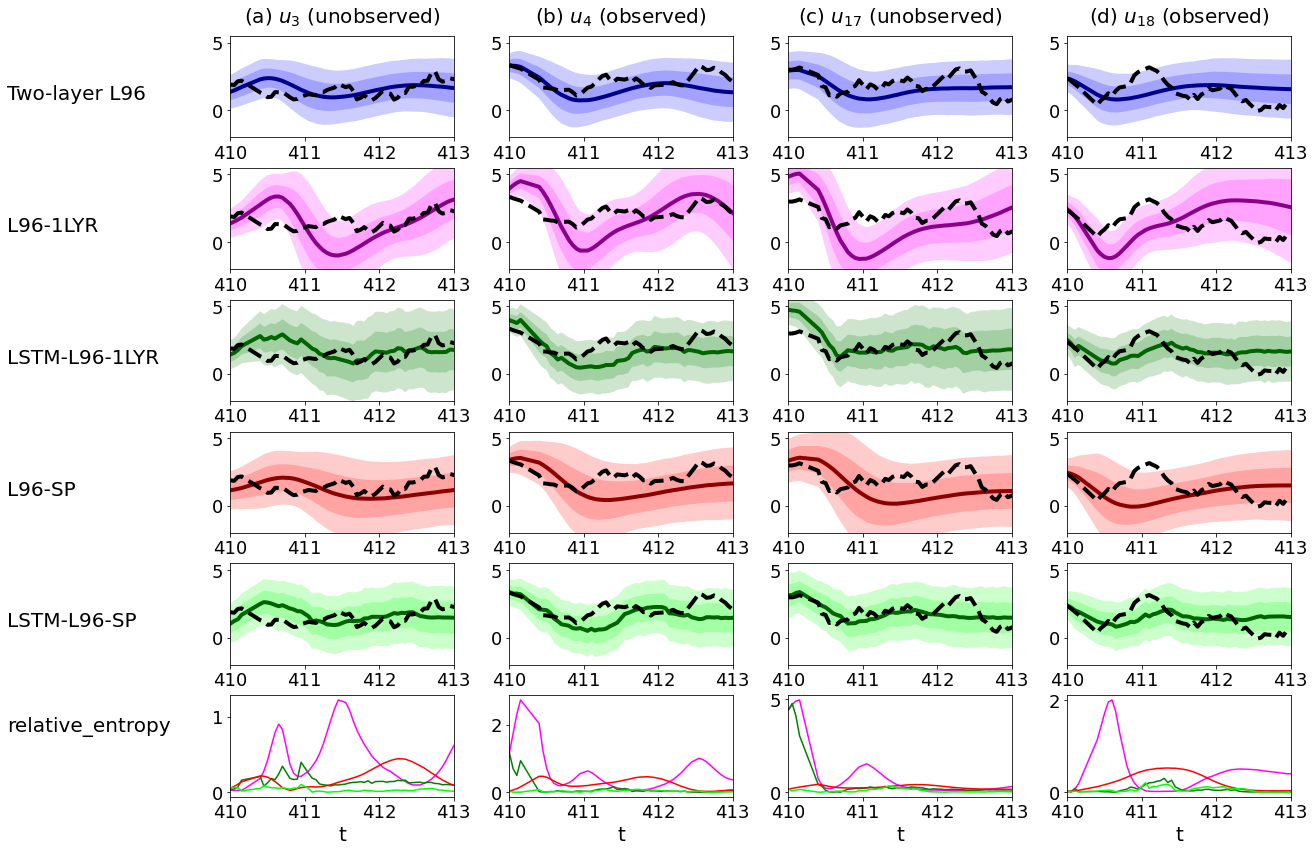

In [58]:
fontsize = 18
plt.rc("axes", titlesize=fontsize + 2)  # using a size in points
plt.rc("xtick", labelsize=fontsize)
plt.rc("ytick", labelsize=fontsize)
plt.rc("legend", fontsize=fontsize)
plt.rc("axes", titlepad=12)

fig, axs = plt.subplots(
    nrows=6,
    ncols=4,
    figsize=(19, 14),
)
x_left = spread_start_time
x_right = spread_start_time + lead_times[-1] * pred_dt - 2

y_top = 4
y_bottom = -4
plt_dims = [2, 3, 16, 17]
titles = [
    "(a) $u_3$ (unobserved)",
    "(b) $u_4$ (observed)",
    "(c) $u_{17}$ (unobserved)",
    "(d) $u_{18}$ (observed)",
]

for i in range(4):
    plt_dim = plt_dims[i]
    u_mean = np.mean(predicts_en_DA[lead_times], axis=1)[:, plt_dim]
    u_std = predicts_en_DA_std[lead_times, plt_dim]
    upper, lower, upper2, lower2 = compute_mean_std(u_mean, u_std)

    axs[0, i].fill_between(
        spread_t[lead_times], upper, lower, facecolor="b", alpha=0.2
    )
    axs[0, i].fill_between(
        spread_t[lead_times], upper2, lower2, facecolor="b", alpha=0.2
    )
    axs[0, i].plot(
        spread_t[lead_times],
        np.mean(predicts_en_DA[lead_times], axis=1)[:, plt_dim],
        "darkblue",
        linewidth=4,
    )
    axs[0, i].plot(
        spread_t[lead_times],
        spread_target[lead_times, plt_dim],
        "--",
        color="black",
        linewidth=4,
    )

    u_mean = np.mean(predicts_en_wrong_DA[lead_times], axis=1)[:, plt_dim]
    u_std = predicts_en_wrong_DA_std[lead_times, plt_dim]
    upper, lower, upper2, lower2 = compute_mean_std(u_mean, u_std)

    axs[3, i].fill_between(
        spread_t[lead_times], upper, lower, facecolor="r", alpha=0.2
    )
    axs[3, i].fill_between(
        spread_t[lead_times], upper2, lower2, facecolor="r", alpha=0.2
    )

    axs[3, i].plot(
        spread_t[lead_times],
        np.mean(predicts_en_wrong_DA, axis=1)[lead_times, plt_dim],
        "darkred",
        linewidth=4,
    )
    axs[3, i].plot(
        spread_t[lead_times],
        spread_target[lead_times, plt_dim],
        "--",
        color="black",
        linewidth=4,
    )

    u_mean = np.mean(predicts_en_lstm_DA_reconstruct[lead_times], axis=1)[
        :, plt_dim
    ]
    u_std = np.std(predicts_en_lstm_DA_reconstruct[lead_times], axis=1)[
        :, plt_dim
    ]
    upper, lower, upper2, lower2 = compute_mean_std(u_mean, u_std)

    axs[4, i].fill_between(
        spread_t[lead_times], upper, lower, facecolor="lime", alpha=0.2
    )
    axs[4, i].fill_between(
        spread_t[lead_times], upper2, lower2, facecolor="lime", alpha=0.2
    )

    axs[4, i].plot(
        spread_t[lead_times],
        np.mean(predicts_en_lstm_DA_reconstruct, axis=1)[lead_times, plt_dim],
        "darkgreen",
        linewidth=4,
    )
    axs[4, i].plot(
        spread_t[lead_times],
        spread_target[lead_times, plt_dim],
        "--",
        color="black",
        linewidth=4,
    )

    u_mean = np.mean(predicts_en_wrong_DA_onelayer[lead_times], axis=1)[
        :, plt_dim
    ]
    u_std = predicts_en_wrong_DA_std_onelayer[lead_times, plt_dim]
    upper, lower, upper2, lower2 = compute_mean_std(u_mean, u_std)

    axs[1, i].fill_between(
        spread_t[lead_times], upper, lower, facecolor="magenta", alpha=0.2
    )
    axs[1, i].fill_between(
        spread_t[lead_times], upper2, lower2, facecolor="magenta", alpha=0.2
    )

    axs[1, i].plot(
        spread_t[lead_times],
        np.mean(predicts_en_wrong_DA_onelayer, axis=1)[lead_times, plt_dim],
        "darkmagenta",
        linewidth=4,
    )
    axs[1, i].plot(
        spread_t[lead_times],
        spread_target[lead_times, plt_dim],
        "--",
        color="black",
        linewidth=4,
    )

    u_mean = np.mean(predicts_en_lstm_DA_reconstruct_onelayer[lead_times], axis=1)[:, plt_dim]
#     u_mean = np.mean(
#         predicts_en_lstm_DA_reconstruct_onelayer_new[lead_times], axis=1
#     )[:, plt_dim]
    #     u_mean = predicts_en_lstm_DA_mean_smoothed_onelayer[lead_times, plt_dim]
    u_std = np.std(
        predicts_en_lstm_DA_reconstruct_onelayer[lead_times], axis=1
    )[:, plt_dim]
    #     u_std = predicts_en_lstm_DA_reconstruct_std_smoothed[lead_times, plt_dim]
    upper, lower, upper2, lower2 = compute_mean_std(u_mean, u_std)

    axs[2, i].fill_between(
        spread_t[lead_times], upper, lower, facecolor="g", alpha=0.2
    )
    axs[2, i].fill_between(
        spread_t[lead_times], upper2, lower2, facecolor="g", alpha=0.2
    )

    axs[2, i].plot(
        spread_t[lead_times],
        u_mean,
        "darkgreen",
        linewidth=4,
    )
    axs[2, i].plot(
        spread_t[lead_times],
        spread_target[lead_times, plt_dim],
        "--",
        color="black",
        linewidth=4,
    )

    re_onelayer = []
    re_onelayer_LSTM = []
    re_SPEKF = []
    re_SPEKF_LSTM = []
    plt_time = 0
    x_ref = predicts_en_DA[plt_time, :, plt_dim][:, np.newaxis]
    x_M = predicts_en_wrong_DA_onelayer[plt_time, :, plt_dim][:, np.newaxis]
    re_onelayer.append(compute_relative_entropy(x_ref, x_M))
    re_onelayer_LSTM.append(compute_relative_entropy(x_ref, x_M))

    x_M = predicts_en_wrong_DA[plt_time, :, plt_dim][:, np.newaxis]
    re_SPEKF.append(compute_relative_entropy(x_ref, x_M))
    re_SPEKF_LSTM.append(compute_relative_entropy(x_ref, x_M))
    for plt_time in lead_times[1:]:
        x_ref = predicts_en_DA[plt_time, :, plt_dim][:, np.newaxis]
        x_M = predicts_en_wrong_DA_onelayer[plt_time, :, plt_dim][
            :, np.newaxis
        ]
        re_onelayer.append(compute_relative_entropy(x_ref, x_M))

        x_M = predicts_en_lstm_DA_reconstruct_onelayer[
            plt_time, :, plt_dim
        ][:, np.newaxis]
        re_onelayer_LSTM.append(compute_relative_entropy(x_ref, x_M))

        x_M = predicts_en_wrong_DA[plt_time, :, plt_dim][:, np.newaxis]
        re_SPEKF.append(compute_relative_entropy(x_ref, x_M))

        x_M = predicts_en_lstm_DA_reconstruct[plt_time, :, plt_dim][
            :, np.newaxis
        ]
        re_SPEKF_LSTM.append(compute_relative_entropy(x_ref, x_M))

    axs[5, i].plot(spread_t[lead_times], re_onelayer, "magenta")
    axs[5, i].plot(spread_t[lead_times], re_onelayer_LSTM, "g")
    axs[5, i].plot(spread_t[lead_times], re_SPEKF, "r")
    axs[5, i].plot(spread_t[lead_times], re_SPEKF_LSTM, "lime")

for i in range(5):
    for j in [
        0,
        2,
    ]:
        axs[i, j].set_ylim([-2, 5.5])
        axs[i, j].set_xlim([x_left, x_right])
        axs[0, j].set_title(titles[j], fontsize=fontsize + 2)
        axs[-1, j].set_xlabel("t", fontsize=fontsize + 2)

for i in range(5):
    for j in [
        1,
        3,
    ]:
        axs[i, j].set_ylim([-2, 5.5])
        axs[i, j].set_xlim([x_left, x_right])
        axs[0, j].set_title(titles[j], fontsize=fontsize + 2, pad=12)
        axs[-1, j].set_xlabel("t", fontsize=fontsize + 2)
for j in range(4):
    axs[5, j].set_xlim([x_left, x_right])
y_loc = 0.8
x_loc = spread_start_time - 3
axs[0, 0].text(x_loc, y_loc, "Two-layer L96", fontsize=fontsize + 2)
axs[3, 0].text(x_loc, y_loc, "L96-SP", fontsize=fontsize + 2)
axs[4, 0].text(x_loc, y_loc, "LSTM-L96-SP", fontsize=fontsize + 2)
axs[1, 0].text(x_loc, y_loc, "L96-1LYR", fontsize=fontsize + 2)
axs[2, 0].text(x_loc, y_loc, "LSTM-L96-1LYR", fontsize=fontsize + 2)
axs[5, 0].text(x_loc, y_loc, "relative_entropy", fontsize=fontsize + 2)

# handles, labels = axs[0, 0].get_legend_handles_labels()
# axs[1, 0].legend(handles, labels, ncol=2, bbox_to_anchor=(4, -0.2))
plt.subplots_adjust(hspace=0.3, wspace=0.25)
savefig(
    fig,
    osp.join(
        output_path,
        model
        + f"_ensemble_spread_DA_{spread_start_time}_re_entropy_50_50.pdf",
    ),
)

In [61]:
mean_std_hidden = np.mean(
    predicts_en_lstm_DA_std[lead_times][:, hidden_dims], axis=1
)
mean_std_obs = np.mean(
    predicts_en_lstm_DA_std[lead_times][:, obs_dims], axis=1
)
mean_std_hidden_onelayer = np.mean(
    predicts_en_lstm_DA_std_onelayer[lead_times][:, hidden_dims], axis=1
)
mean_std_obs_onelayer = np.mean(
    predicts_en_lstm_DA_std_onelayer[lead_times][:, obs_dims], axis=1
)

In [62]:
mean_std_hidden[-1] = mean_std_hidden[-2]
mean_std_obs[-1] = mean_std_obs[-2]
mean_std_hidden_onelayer[-1] = mean_std_hidden_onelayer[-2]
mean_std_obs_onelayer[-1] = mean_std_obs_onelayer[-2]

In [63]:
long_prediction = np.load(output_path + "/long_prediction.npz")
long_prediction_en = long_prediction["long_prediction"]
long_prediction_target = long_prediction["target"]

(0.0, 1.1720540327513929)

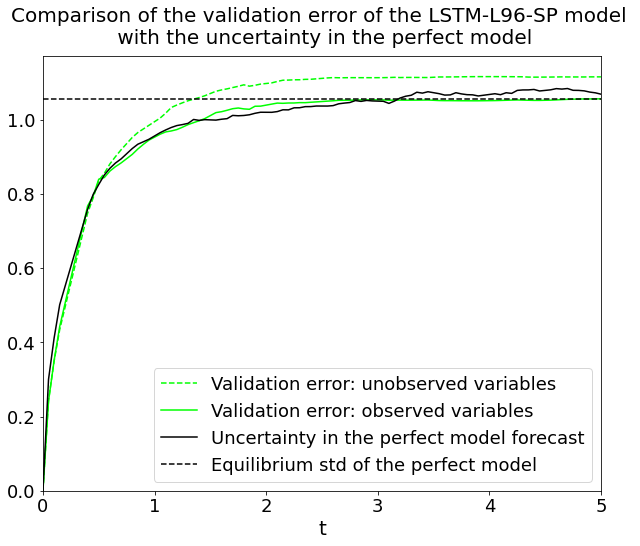

In [64]:
fig = plt.figure(figsize=(10, 8))

plt.plot(
    spread_t[lead_times] - spread_start_time,
    mean_std_hidden,
    "--",
    color="lime",
    label="Validation error: unobserved variables",
)
plt.plot(
    spread_t[lead_times] - spread_start_time,
    mean_std_obs,
    color="lime",
    label="Validation error: observed variables",
)

plt.plot(
    spread_t[lead_times] - spread_start_time,
    np.mean(
        np.sqrt(
            np.mean((long_prediction_en - long_prediction_target) ** 2, axis=3)
        )[0, lead_times, :dim_I],
        axis=1,
    ),
    color="black",
    label="Uncertainty in the perfect model forecast",
)
plt.plot(
    [0, 5],
    [
        np.std(true_state[obs_idx, :dim_I], axis=0).mean(),
        np.std(true_state[obs_idx, :dim_I], axis=0).mean(),
    ],
    "--",
    color="black",
    label="Equilibrium std of the perfect model",
)
plt.xlabel("t", fontsize=20)
plt.title(
    "Comparison of the validation error of the LSTM-L96-SP model \n with the uncertainty in the perfect model"
)
plt.legend()
plt.xlim([0, 5])
plt.ylim(bottom=0)
savefig(
    fig,
    osp.join(
        output_path,
        model + f"_lstm_uncertainty_{spread_start_time}_new.pdf",
    ),
)

# sampling plot

In [99]:
gamma_ensembles = data_sampling["gamma_ensembles"][:, :, :10]
wrong_state = data_sampling["wrong_state"]
gamma_mean_smooth = data_sampling["gamma_mean_smooth"]
gamma_cov_smooth = data_sampling["gamma_cov_smooth"]

wrong_state_onelayer = data_sampling_onelayer["wrong_state_onelayer"]
gamma_ensembles_onelayer = data_sampling_onelayer["gamma_ensembles_onelayer"][
    :, :, :10
]
gamma_mean_smooth_onelayer = data_sampling_onelayer[
    "gamma_mean_smooth_onelayer"
]
gamma_cov_smooth_onelayer = data_sampling_onelayer["gamma_cov_smooth_onelayer"]

In [100]:
if n_steps > 200000:
    burnin = 600  # in dt space
else:
    burnin = 150
obs_burnin = burnin // K  # in obs_dt space

auto_obs_steps = obs_n_steps - obs_burnin
t_auto = np.linspace(0, (auto_obs_steps - 1) * obs_dt, auto_obs_steps)
acf_u_truth = np.zeros((auto_obs_steps, model_dim))
acf_u_sampled = np.zeros((auto_obs_steps, model_dim))
acf_u_smooth = np.zeros((auto_obs_steps, model_dim))
acf_u_wrong = np.zeros((auto_obs_steps, model_dim))
for i in tqdm(range(model_dim)):
    acf_u_truth[:, i] = estimated_autocorrelation(
        true_state[obs_idx, i][obs_burnin:]
    )
    acf_u_sampled[:, i] = estimated_autocorrelation(
        gamma_ensembles[:, i, 0][obs_burnin:]
    )
    acf_u_smooth[:, i] = estimated_autocorrelation(
        gamma_mean_smooth[:, i][obs_burnin:]
    )
    acf_u_wrong[:, i] = estimated_autocorrelation(
        wrong_state[obs_idx, i][obs_burnin:]
    )

100%|██████████| 200/200 [00:34<00:00,  5.76it/s]


In [101]:
acf_u_sampled_onelayer = np.zeros((auto_obs_steps, dim_I))
acf_u_smooth_onelayer = np.zeros((auto_obs_steps, dim_I))
acf_u_wrong_onelayer = np.zeros((auto_obs_steps, dim_I))
for i in tqdm(range(dim_I)):
    acf_u_wrong_onelayer[:, i] = estimated_autocorrelation(
        wrong_state_onelayer[obs_idx, i][obs_burnin:]
    )
    acf_u_sampled_onelayer[:, i] = estimated_autocorrelation(
        gamma_ensembles[:, i, 0][obs_burnin:]
    )
    acf_u_smooth_onelayer[:, i] = estimated_autocorrelation(
        gamma_mean_smooth_onelayer[:, i][obs_burnin:]
    )

100%|██████████| 40/40 [00:04<00:00,  9.05it/s]


In [102]:
plt_dims = [0] + [dim_I + i for i in range(dim_J)]
print(plt_dims)

[0, 40, 41, 42, 43]


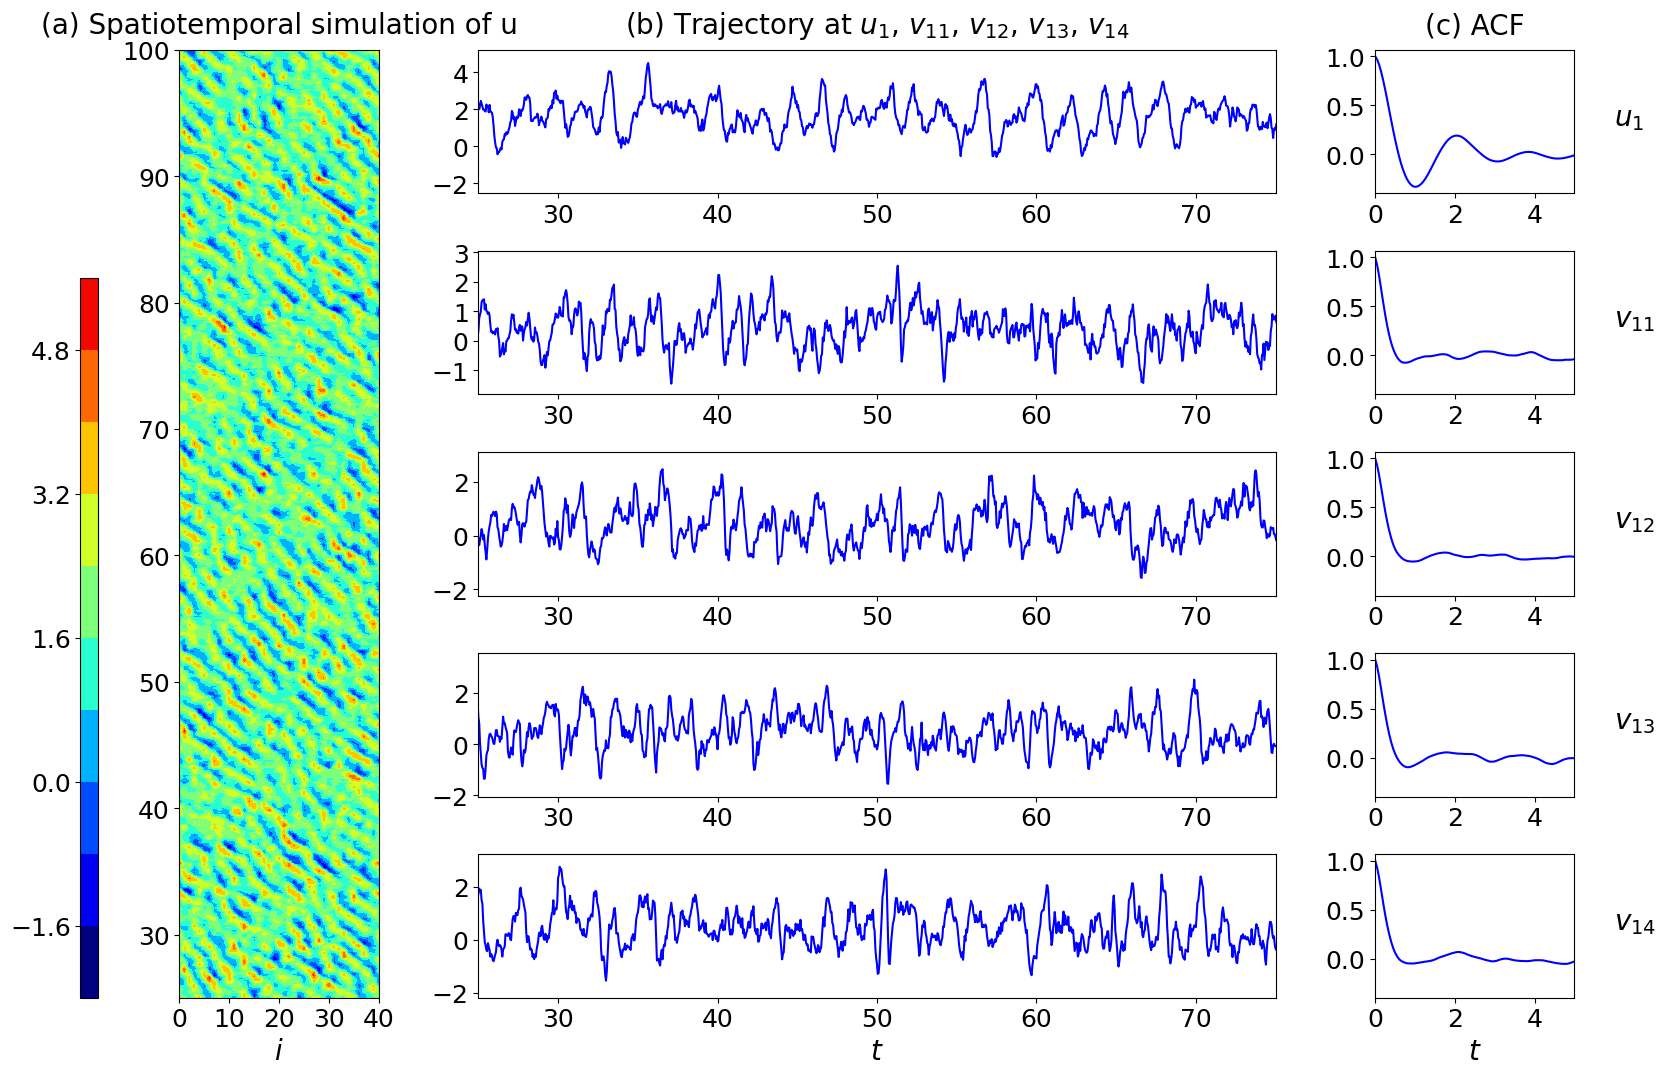

In [114]:
plt.rc("axes", titlepad=12)
fontsize = 18
plt.rc("axes", titlesize=fontsize + 2)
plt.rc("axes", labelsize=fontsize + 2)
plt.rc("xtick", labelsize=fontsize)
plt.rc("ytick", labelsize=fontsize)
plt.rc("legend", fontsize=fontsize)

fig, axs = plt.subplots(
    ncols=3, nrows=5, figsize=(18, 12), gridspec_kw={"width_ratios": [1, 4, 1]}
)
gs = axs[-1, -1].get_gridspec()
for ax in axs[:, 0]:
    ax.remove()
axbig = fig.add_subplot(gs[:, 0])

x_left = 25
x_right = 100
t_start = int(x_left / obs_dt)
t_end = int(x_right / obs_dt) + 1


x_left1 = 25
x_right2 = 75
vmax = 6
vmin = -2
X, Y = np.meshgrid(np.arange(0, (dim_I + 1)), t_obs[t_start:t_end])
Z = plot_u(true_state)[obs_idx][t_start:t_end]
cf = axbig.contourf(X, Y, Z, 10, cmap="jet", vmin=vmin, vmax=vmax)

axbig.set_title("(a) Spatiotemporal simulation of u", pad=12)
cax = fig.add_axes([0.07, 0.11, 0.01, 0.6])
cbar = fig.colorbar(cf, cax=cax, ticklocation="left")

axbig.set_xlabel("$i$")

for i in range(len(plt_dims)):
    plt_dim = plt_dims[i]
    u = true_state[obs_idx, plt_dim]
    axs[i, 1].plot(t_obs, u, "b")
    axs[i, 1].set_xlim([x_left1, x_right2])
    kde_u, u_axis = compute_kde_axis(u, num=200)
    axs[i, 2].plot(t_auto, acf_u_truth[:, plt_dim], "b")
    axs[i, 2].set_xlim([0, 5])

    if i == 0:
        y_lim = axs[i, 2].get_ylim()
    else:
        axs[i, 2].set_ylim(y_lim)
axs[0, 1].set_title(
    "(b) Trajectory at $u_1$, $v_{11}$, $v_{12}$, $v_{13}$, $v_{14}$"
)
axs[0, 2].set_title("(c) ACF")
axs[-1, 1].set_xlabel("$t$")
axs[-1, 2].set_xlabel("$t$")

for i in range(5):
    axs[i, 2].locator_params(nbins=3)

x_loc = 6
y_loc = 0.3
axs[0, -1].text(x_loc, y_loc, "$u_1$", fontsize=fontsize + 2)
axs[1, -1].text(x_loc, y_loc, "$v_{11}$", fontsize=fontsize + 2)
axs[2, -1].text(x_loc, y_loc, "$v_{12}$", fontsize=fontsize + 2)
axs[3, -1].text(x_loc, y_loc, "$v_{13}$", fontsize=fontsize + 2)
axs[4, -1].text(x_loc, y_loc, "$v_{14}$", fontsize=fontsize + 2)

plt.subplots_adjust(wspace=0.25, hspace=0.4, top=0.9)
savefig(fig, osp.join(output_path, model + "_trajectory_truth" + ".pdf"))

plt.rcdefaults()

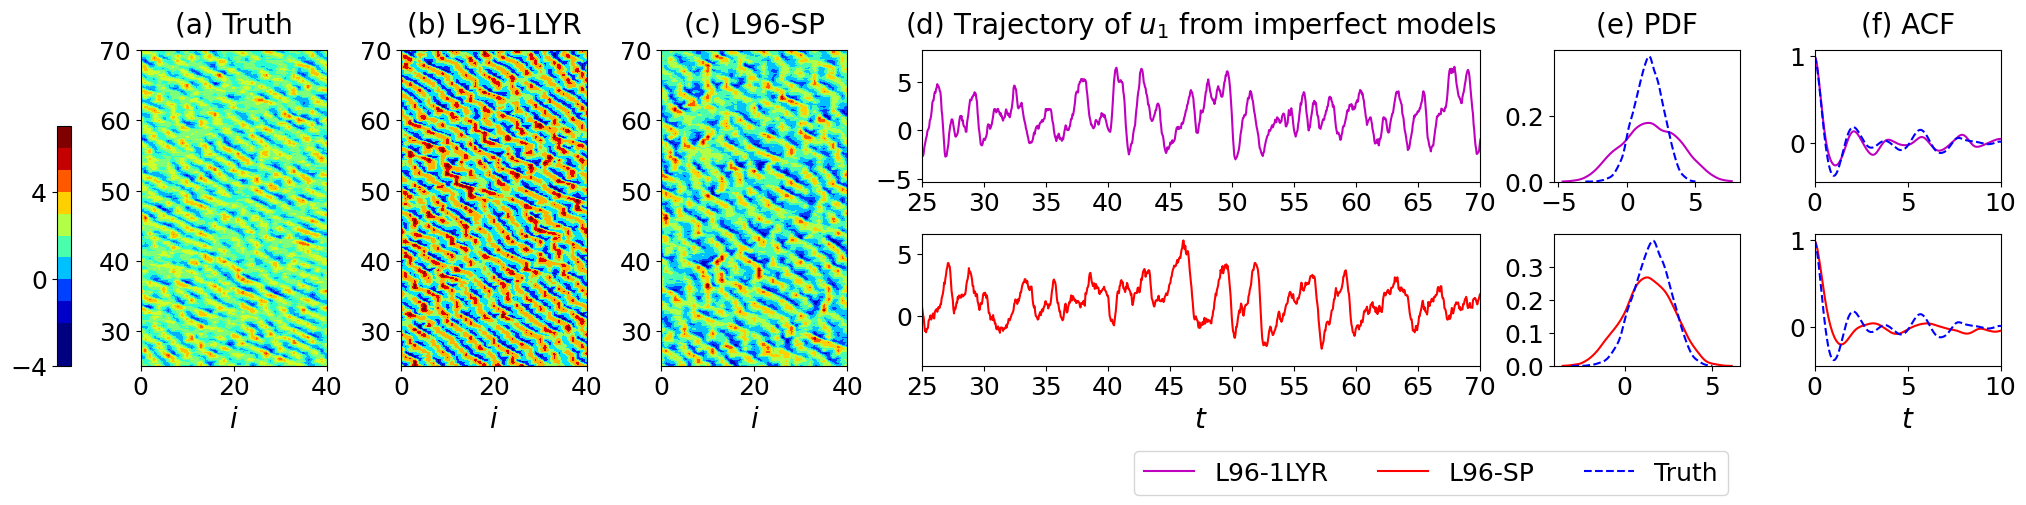

In [111]:
plt.rc("axes", titlepad=12)
fontsize = 18
plt.rc("axes", titlesize=fontsize + 2)
plt.rc("axes", labelsize=fontsize + 2)
plt.rc("xtick", labelsize=fontsize)
plt.rc("ytick", labelsize=fontsize)
plt.rc("legend", fontsize=fontsize)

fig, axs = plt.subplots(
    ncols=6,
    nrows=2,
    figsize=(24, 4),
    gridspec_kw={"width_ratios": [1, 1, 1, 3, 1, 1]},
)
gs = axs[-1, -1].get_gridspec()


x_left = 25
x_right = 70
t_start = int(x_left / obs_dt)
t_end = int(x_right / obs_dt) + 1

vmax = 6
vmin = -2

for ax in axs[:, 0]:
    ax.remove()
axbig = fig.add_subplot(gs[:, 0])
X, Y = np.meshgrid(np.arange(0, (dim_I + 1)), t_obs[t_start:t_end])
Z = plot_u(true_state)[obs_idx][t_start:t_end]
cf = axbig.contourf(X, Y, Z, 10, cmap="jet", vmin=vmin, vmax=vmax)
axbig.set_title("(a) Truth")
axbig.locator_params(axis="x", nbins=3)
axbig.locator_params(axis="y", nbins=8)
axbig.set_xlabel("$i$")

for ax in axs[:, 1]:
    ax.remove()
axbig = fig.add_subplot(gs[:, 1])
X, Y = np.meshgrid(np.arange(0, (dim_I + 1)), t_obs[t_start:t_end])
Z = plot_u(wrong_state_onelayer)[obs_idx][t_start:t_end]
cf = axbig.contourf(X, Y, Z, 10, cmap="jet", vmin=vmin, vmax=vmax)
axbig.set_title("(b) L96-1LYR")
axbig.locator_params(axis="x", nbins=3)
axbig.locator_params(axis="y", nbins=8)
axbig.set_xlabel("$i$")


for ax in axs[:, 2]:
    ax.remove()
axbig = fig.add_subplot(gs[:, 2])
X, Y = np.meshgrid(np.arange(0, (dim_I + 1)), t_obs[t_start:t_end])
Z = plot_u(wrong_state)[obs_idx][t_start:t_end]
cf = axbig.contourf(X, Y, Z, 10, cmap="jet", vmin=vmin, vmax=vmax)
axbig.set_title("(c) L96-SP")
axbig.locator_params(axis="x", nbins=3)
axbig.locator_params(axis="y", nbins=8)
axbig.set_xlabel("$i$")


# [0.07, 0.11, 0.01, 0.6]
cax = fig.add_axes([0.09, 0.11, 0.006, 0.6])
cbar = fig.colorbar(cf, cax=cax, ticklocation="left")
cbar.ax.locator_params(nbins=5)

plt_dim = 1


u = wrong_state[obs_idx, plt_dim]
axs[1, 3].plot(t_obs, u, "r")
kde_u, u_axis = compute_kde_axis(u, num=200)
axs[1, 4].plot(u_axis, kde_u(u_axis), color="r", label="L96-SP")
u = true_state[obs_idx, plt_dim]
kde_u, u_axis = compute_kde_axis(u, num=200)
axs[1, 4].plot(u_axis, kde_u(u_axis), "--", color="b", label="Truth")
axs[1, 5].plot(t_auto, acf_u_wrong[:, plt_dim], "r")
axs[1, 5].plot(t_auto, acf_u_truth[:, plt_dim], "--", color="b")


u = wrong_state_onelayer[obs_idx, plt_dim]
axs[0, 3].plot(t_obs, u, "m")
kde_u, u_axis = compute_kde_axis(u, num=200)
axs[0, 4].plot(u_axis, kde_u(u_axis), color="m", label="L96-1LYR")
axs[0, 5].plot(t_auto, acf_u_wrong_onelayer[:, plt_dim], "m")
u = true_state[obs_idx, plt_dim]
kde_u, u_axis = compute_kde_axis(u, num=200)
axs[0, 4].plot(u_axis, kde_u(u_axis), "--", color="b", label="Truth")
axs[0, 5].plot(t_auto, acf_u_truth[:, plt_dim], "--", color="b")

axs[0, 3].set_xlim([x_left, x_right])
axs[1, 3].set_xlim([x_left, x_right])

axs[0, 4].set_ylim(bottom=0)
axs[1, 4].set_ylim(bottom=0)

axs[1, 5].set_xlim([0, 10])
axs[0, 5].set_xlim([0, 10])

axs[0, 3].locator_params(axis="y", nbins=3)
axs[0, 5].locator_params(nbins=3)
axs[1, 5].locator_params(nbins=3)
axs[0, 4].locator_params(nbins=3)

axs[0, 3].set_title("(d) Trajectory of $u_1$ from imperfect models", pad=12)
axs[0, 4].set_title("(e) PDF")
axs[0, 5].set_title("(f) ACF")

handles1, labels1 = axs[0, 4].get_legend_handles_labels()
handles2, labels2 = axs[1, 4].get_legend_handles_labels()
handles = [handles1[0]] + handles2
labels = [labels1[0]] + labels2

axs[-1, 4].legend(
    handles, labels, ncol=3, loc="upper right", bbox_to_anchor=(1, -0.55)
)
axs[-1, 0].set_xlabel("$u$", fontsize=fontsize + 2)
axs[-1, 3].set_xlabel("$t$", fontsize=fontsize + 2)
axs[-1, 5].set_xlabel("$t$", fontsize=fontsize + 2)

plt.subplots_adjust(wspace=0.3, hspace=0.4, top=0.9)
savefig(
    fig, osp.join(output_path, model + "_trajectory_truth_vs_wrong" + ".pdf")
)

plt.rcdefaults()

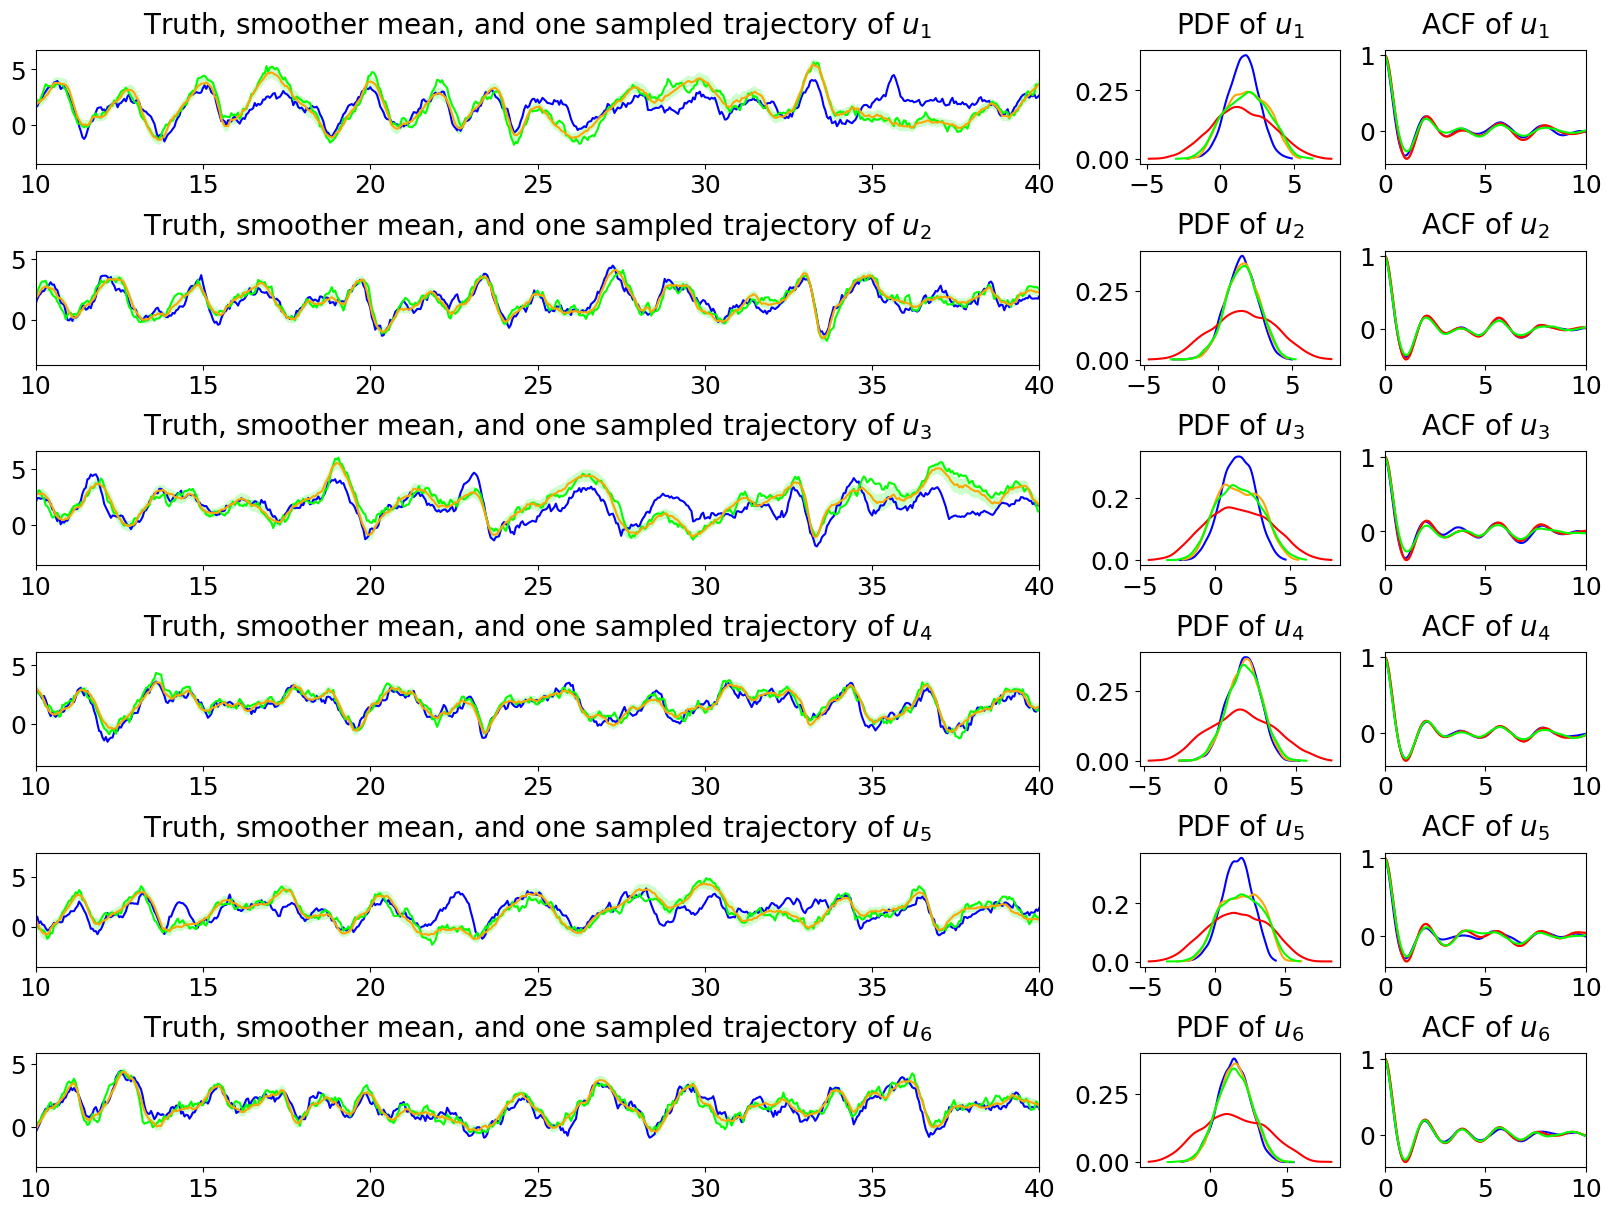

In [129]:
fig, axs = plt.subplots(
    nrows=6,
    ncols=3,
    figsize=(16, 2 * (6)),
    constrained_layout=True,
    gridspec_kw={"width_ratios": [5, 1, 1]},
)

x_left = 10
x_right = 40

for i in range(6):
    plt_dim = i
    axs[i, 0].plot(
        t_obs[obs_burnin:],
        true_state[obs_idx, plt_dim][obs_burnin:],
        "b",
        label="Truth",
    )
    axs[i, 0].set_xlim([x_left, x_right])
    smoothing_upper_u = gamma_mean_smooth_onelayer[:, plt_dim][
        obs_burnin:
    ] + np.sqrt(gamma_cov_smooth_onelayer[:, plt_dim, plt_dim][obs_burnin:])
    smoothing_lower_u = gamma_mean_smooth_onelayer[:, plt_dim][
        obs_burnin:
    ] - np.sqrt(gamma_cov_smooth_onelayer[:, plt_dim, plt_dim][obs_burnin:])
    u = true_state[obs_idx, plt_dim][obs_burnin:]
    kde_u, u_axis = compute_kde_axis(u)
    axs[i, 1].plot(u_axis, kde_u(u_axis), color="b")
    axs[i, 2].plot(t_auto, acf_u_truth[:, plt_dim], color="b")
    u = gamma_mean_smooth_onelayer[:, plt_dim][obs_burnin:]
    kde_u, u_axis = compute_kde_axis(u)
    axs[i, 1].plot(u_axis, kde_u(u_axis), color="orange")
    axs[i, 2].plot(t_auto, acf_u_smooth[:, plt_dim], color="orange")

    u = wrong_state_onelayer[obs_idx, plt_dim][obs_burnin:]
    kde_u, u_axis = compute_kde_axis(u)
    axs[i, 1].plot(u_axis, kde_u(u_axis), color="r")
    axs[i, 2].plot(t_auto, acf_u_smooth[:, plt_dim], color="r")

    u = gamma_ensembles_onelayer[:, i, 0][obs_burnin:]
    kde_u, u_axis = compute_kde_axis(u)
    axs[i, 1].plot(u_axis, kde_u(u_axis), color="lime")
    axs[i, 2].plot(t_auto, acf_u_sampled[:, plt_dim], color="lime")

    axs[i, 0].plot(
        t_obs[obs_burnin:],
        gamma_ensembles_onelayer[:, plt_dim, 0][obs_burnin:],
        "lime",
        label="Sampled trajectories",
    )
    axs[i, 0].fill_between(
        t_obs[obs_burnin:],
        smoothing_upper_u,
        smoothing_lower_u,
        facecolor="lime",
        alpha=0.2,
        label="1 std from smoother mean",
    )

    axs[i, 0].plot(
        t_obs[obs_burnin:],
        gamma_mean_smooth_onelayer[:, plt_dim][obs_burnin:],
        "orange",
        label="Smoother mean",
    )
    axs[i, 0].set_xlim([x_left, x_right])

    axs[i, 0].set_title(
        f"Truth, smoother mean, and one sampled trajectory of $u_{plt_dim + 1}$"
    )
    axs[i, 1].set_title(f"PDF of $u_{plt_dim + 1}$")
    axs[i, 2].set_title(f"ACF of $u_{plt_dim + 1}$")

    axs[i, 2].set_xlim([0, 10])
handles, labels = axs[0, 0].get_legend_handles_labels()
# axs[-1, 0].legend(
#     handles, labels, ncol=4, loc="upper right", bbox_to_anchor=(1, -0.20)
# )
# savefig(
#     fig,
#     osp.join(output_path, model +  "_PDFs_ACFs_onelayer.pdf"),
# )

In [ ]:
fig, axs = plt.subplots(
    nrows=10,
    ncols=3,
    figsize=(16, 2 * (10)),
    constrained_layout=True,
    gridspec_kw={"width_ratios": [5, 1, 1]},
)

x_left = 10
x_right = 40
for i in range(10):
    axs[i, 0].plot(
        t_obs[obs_burnin:],
        true_state[obs_idx, i][obs_burnin:],
        "b",
        label="Truth",
    )
    axs[i, 0].set_xlim([x_left, x_right])
    smoothing_upper_u = gamma_mean_smooth[:, i][obs_burnin:] + np.sqrt(
        gamma_cov_smooth[:, i, i][obs_burnin:]
    )
    smoothing_lower_u = gamma_mean_smooth[:, i][obs_burnin:] - np.sqrt(
        gamma_cov_smooth[:, i, i][obs_burnin:]
    )
    u = true_state[obs_idx, i][obs_burnin:]
    kde_u, u_axis = compute_kde_axis(u)
    axs[i, 1].plot(u_axis, kde_u(u_axis), color="b")
    axs[i, 2].plot(t_auto, acf_u_truth[:, i], color="b")
    u = gamma_mean_smooth[:, i][obs_burnin:]
    kde_u, u_axis = compute_kde_axis(u)
    axs[i, 1].plot(u_axis, kde_u(u_axis), color="orange")
    axs[i, 2].plot(t_auto, acf_u_smooth[:, i], color="orange")

    u = gamma_ensembles[:, i, 0][obs_burnin:]
    kde_u, u_axis = compute_kde_axis(u)
    axs[i, 1].plot(u_axis, kde_u(u_axis), color="lime")
    axs[i, 2].plot(t_auto, acf_u_sampled[:, i], color="lime")

    axs[i, 0].plot(
        t_obs[obs_burnin:],
        gamma_ensembles[:, i, 0][obs_burnin:],
        "lime",
        label="Sampled trajectories",
    )
    axs[i, 0].fill_between(
        t_obs[obs_burnin:],
        smoothing_upper_u,
        smoothing_lower_u,
        facecolor="lime",
        alpha=0.2,
        label="1 std from smoother mean",
    )

    axs[i, 0].plot(
        t_obs[obs_burnin:],
        gamma_mean_smooth[:, i][obs_burnin:],
        "orange",
        label="Smoother mean",
    )
    axs[i, 0].set_xlim([x_left, x_right])

    axs[i, 0].set_title(
        f"Truth, smoother mean, and one sampled trajectory of $u_{i + 1}$"
    )
    axs[i, 1].set_title(f"PDF of $u_{i + 1}$")
    axs[i, 2].set_title(f"ACF of $u_{i + 1}$")

    axs[i, 2].set_xlim([0, 10])
handles, labels = axs[0, 0].get_legend_handles_labels()
axs[-1, 0].legend(
    handles, labels, ncol=4, loc="upper right", bbox_to_anchor=(1, -0.20)
)
savefig(
    fig,
    osp.join(output_path, model + "_PDFs_ACFs_SPEKF.pdf"),
)